# Double Q-Learning Agent for Stock Trading

This repository contains an implementation of a Q-learning agent designed to make stock trading decisions based on historical price data. The agent learns an optimal trading strategy through interaction with the market environment using the Q-learning algorithm.

## Agent Architecture

The agent consists of a deep neural network that takes in a state representation and outputs Q-values for each possible action (buy, sell, hold). The state is represented by a sliding window of price differences over a specified window size. The neural network architecture includes the following components:

- Input layer: Accepts the state representation.
- Hidden layer: Applies the ReLU activation function to the input.
- Output layer: Produces the Q-values for each action using a linear activation function.

The agent also maintains a target network, which is a copy of the main network used for stable Q-value estimation during training.

## Q-Learning Process

The Q-learning process follows these steps:

1. **Initialization**: The agent's neural networks (main and target) are initialized with random weights, and the replay memory is emptied.

2. **State Representation**: At each time step, the agent observes the current state of the market, which is represented by a sliding window of price differences.

3. **Action Selection**: The agent selects an action based on an epsilon-greedy policy. With probability epsilon, the agent explores by selecting a random action, and with probability 1-epsilon, the agent exploits by selecting the action with the highest Q-value.

4. **State Transition**: The agent executes the selected action and observes the next state and the reward received from the market.

5. **Replay Memory**: The agent stores the transition (state, action, reward, next state, done) in the replay memory.

6. **Q-Value Update**: The agent samples a batch of transitions from the replay memory and updates the Q-values using the Q-learning update rule. The target Q-value for each transition is calculated based on the reward and the maximum Q-value of the next state obtained from the target network.

7. **Neural Network Update**: The agent's main neural network is updated using the sampled batch of transitions and the Q-learning loss function. The optimizer adjusts the network's weights to minimize the loss.

8. **Target Network Update**: After a specified number of steps, the target network is updated by copying the weights from the main network.

9. **Iteration**: Steps 3-8 are repeated for a specified number of episodes or until convergence.

## Trading Simulation

The trading simulation is performed using the trained Q-learning agent. The agent makes buy and sell decisions based on the current state of the market. The state is represented by a sliding window of price differences.

The agent's decisions are as follows:

- **Buy**: If the agent selects the buy action and there is sufficient funds, a unit of stock is purchased, and the inventory and balance are updated accordingly.

- **Sell**: If the agent selects the sell action and there is stock in the inventory, a unit of stock is sold, and the balance is updated based on the selling price.

- **Hold**: If the agent selects the hold action, no action is taken.

The simulation keeps track of the buying and selling states, total gains, investment percentage, and the final portfolio value.

## Usage

To use the Q-learning agent for stock trading:

1. Prepare the historical price data as a list of closing prices.

2. Set the initial parameters, such as the initial money, window size, and skip size.

3. Create an instance of the `Agent` class with the desired state size, window size, trend, skip size, batch size, learning rate, and device.

4. Call the `train` method to train the agent for a specified number of iterations, providing the necessary parameters such as the number of iterations, checkpoint frequency, and initial money.

5. Evaluate the agent's performance using the `buy` method, which simulates the trading process and returns the buy and sell states, total gains, investment percentage, and the final portfolio value.

6. Analyze the results and adjust the hyperparameters as needed to optimize the trading strategy.

## Requirements

- Python 3.x
- PyTorch
- NumPy

In [3]:
!pip3 install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 MB 39.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 60.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 33.9 MB/s eta 0:00:00


In [1]:
from utils import *
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Configure Modeling Parameters and Fetch Data

Enter a ticker and date range you would like to build the model on.  This model takes a a single ticker's data.  Also enter a training size for the proportion of the data you want to include in your training set vs. your test set.

In [2]:
# stock configs
ticker = ['GOOG']
start_date = '2022-04-01'
end_date = '2024-04-05'

# model configs
train_size = 0.8

In [3]:
# Data Fetching
data = fetch_stock_data(ticker, start_date, end_date)[ticker[0]]
data.reset_index(drop=False, inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)

print(data.shape)
included_days = len(data)
data.head()

(504, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2022-04-01,140.009995,140.949997,138.796997,140.699997,23480000,0.0,0.0
1,2022-04-04,140.824493,144.043747,140.824493,143.642502,19076000,0.0,0.0
2,2022-04-05,143.399506,143.589996,140.943497,141.063004,19256000,0.0,0.0
3,2022-04-06,139.161499,139.848495,136.418106,137.175995,23574000,0.0,0.0
4,2022-04-07,136.617996,137.701508,134.857254,136.464996,19448000,0.0,0.0


In [4]:
# Define the neural network model
class Model(nn.Module):
    def __init__(self, input_size, output_size, layer_size):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_size, layer_size)
        self.layer2 = nn.Linear(layer_size, output_size)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x

In [6]:

# Define the trading agent
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size, learning_rate, device):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.device = device

        self.output_size = 3  # Buy, Sell, Hold
        self.layer_size = 500
        self.epsilon = 0.5  # Exploration rate
        self.decay_rate = 0.005  # Epsilon decay rate
        self.min_epsilon = 0.1  # Minimum exploration rate
        self.gamma = 0.99  # Discount factor
        self.memories = []  # Memory for storing experiences
        self.copy_steps = 1000  # Number of steps to update the target network
        self.copy_counter = 0  # Counter for updating the target network
        self.memory_size = 300  # Maximum size of the memory

        # Initialize the main and target models
        self.model = Model(self.state_size, self.output_size, self.layer_size).to(self.device)
        self.model_target = Model(self.state_size, self.output_size, self.layer_size).to(self.device)
        self.model_target.load_state_dict(self.model.state_dict())

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

    # Update the target model with the weights of the main model
    def _assign(self):
        self.model_target.load_state_dict(self.model.state_dict())

    # Store an experience in memory
    def _memorize(self, state, action, reward, new_state, done):
        self.memories.append((state, action, reward, new_state, done))
        if len(self.memories) > self.memory_size:
            self.memories.pop(0)

    # Select an action based on the current state
    def _select_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.output_size)
        else:
            state = torch.tensor(state, dtype=torch.float32).to(self.device)
            action = self.model(state).argmax().item()
        return action

    # Construct the input and target values for training
    def _construct_memories(self, replay):
        states = torch.tensor([a[0] for a in replay], dtype=torch.float32).to(self.device)
        new_states = torch.tensor([a[3] for a in replay], dtype=torch.float32).to(self.device)
        Q = self.model(states).detach().cpu().numpy()
        Q_target = self.model_target(new_states).detach().cpu().numpy()
        Q_new = self.model(new_states).detach().cpu().numpy()

        X = np.empty((len(replay), self.state_size))
        Y = np.empty((len(replay), self.output_size))
        for i, (state, action, reward, new_state, done) in enumerate(replay):
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * Q_target[i, np.argmax(Q_new[i])]
            X[i] = state
            Y[i] = target
        return torch.tensor(X, dtype=torch.float32).to(self.device), torch.tensor(Y, dtype=torch.float32).to(self.device)

    # Make predictions using the model
    def predict(self, inputs):
        with torch.no_grad():
            inputs = torch.tensor(inputs, dtype=torch.float32).to(self.device)
            return self.model(inputs).cpu().numpy()

    # Get the predicted action for a given sequence
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)

    # Get the state representation for a given time step
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d: t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0: t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)

    # Simulate the buying process
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f' % (t, self.trend[t], initial_money))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, self.trend[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    # Train the agent
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                self.copy_counter += 1
                if self.copy_counter % self.copy_steps == 0:
                    self._assign()

                action = self._select_action(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)

                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.memories), self.batch_size)
                replay = random.sample(self.memories, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)

                loss = self.loss_fn(self.model(X), Y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                self.epsilon = self.min_epsilon + (1.0 - self.min_epsilon) * np.exp(-self.decay_rate * i)

            if (i + 1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f' % (i + 1, total_profit, loss.item(), starting_money))

In [8]:
close = data.Close.values.tolist()

initial_money = 10000
learning_rate = 0.001
window_size = 30
skip = 1
batch_size = 32

# Determine the device to use (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the Agent
agent = Agent(state_size=window_size,
              window_size=window_size,
              trend=close,
              skip=skip,
              batch_size=batch_size,
              learning_rate=learning_rate,
              device=device)

In [9]:
# Train the agent
agent.train(iterations=50, checkpoint=10, initial_money=initial_money)

/var/folders/0c/6nxq1mwn3g99r6b2tcmbw3xw0000gn/T/ipykernel_78811/184586483.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  states = torch.tensor([a[0] for a in replay], dtype=torch.float32).to(self.device)


epoch: 10, total rewards: 70.532997.3, cost: 0.000499, total money: 7578.863029
epoch: 20, total rewards: 288.454132.3, cost: 0.000315, total money: 9687.274139
epoch: 30, total rewards: -199.004570.3, cost: 0.000272, total money: 8649.425438
epoch: 40, total rewards: 170.692993.3, cost: 0.000227, total money: 7712.953003
epoch: 50, total rewards: -52.678627.3, cost: 0.000087, total money: 9634.451378


In [10]:
# Evaluate the agent's performance
states_buy, states_sell, total_gains, invest = agent.buy(initial_money)

day 7: buy 1 unit at price 128.374496, total balance 9871.625504
day 8, sell 1 unit at price 130.285995, investment 1.489002 %, total balance 10001.911499,
day 9: buy 1 unit at price 127.252998, total balance 9874.658501
day 10, sell 1 unit at price 127.960999, investment 0.556372 %, total balance 10002.619499,
day 13: buy 1 unit at price 124.937500, total balance 9877.681999
day 16: buy 1 unit at price 119.505997, total balance 9758.176003
day 17, sell 1 unit at price 115.020500, investment -7.937569 %, total balance 9873.196503,
day 18, sell 1 unit at price 119.411499, investment -0.079074 %, total balance 9992.608002,
day 19: buy 1 unit at price 114.966499, total balance 9877.641502
day 20, sell 1 unit at price 117.156998, investment 1.905336 %, total balance 9994.798500,
day 27: buy 1 unit at price 113.960999, total balance 9880.837502
day 28: buy 1 unit at price 113.161003, total balance 9767.676498
day 29, sell 1 unit at price 116.515503, investment 2.241560 %, total balance 9884

In [11]:
import plotly.graph_objects as go

starting_money = 10000

close = data['Close']
final_share_price = close[len(close) - 1]  # Final share price
total_portfolio_value = starting_money + total_gains  # Total portfolio value
total_gains = total_portfolio_value - starting_money

fig = go.Figure()

# Candlestick trace
fig.add_trace(go.Candlestick(x=data.index,
                             open=data['Open'],
                             high=data['High'],
                             low=data['Low'],
                             close=data['Close']))

# Buy signals trace
fig.add_trace(go.Scatter(x=[data.index[i] for i in states_buy],
                         y=[close[i] for i in states_buy],
                         mode='markers',
                         name='Buy Signals',
                         marker=dict(symbol='triangle-up', size=10, color='green')))

# Sell signals trace
fig.add_trace(go.Scatter(x=[data.index[i] for i in states_sell],
                         y=[close[i] for i in states_sell],
                         mode='markers',
                         name='Sell Signals',
                         marker=dict(symbol='triangle-down', size=10, color='red')))

# Set layout
fig.update_layout(
    title=f'Total Gains: {total_gains:.2f}, Total Portfolio Value: {total_portfolio_value:.2f}',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_dark',
    legend=dict(x=0, y=1, orientation='h')
)

fig.show()

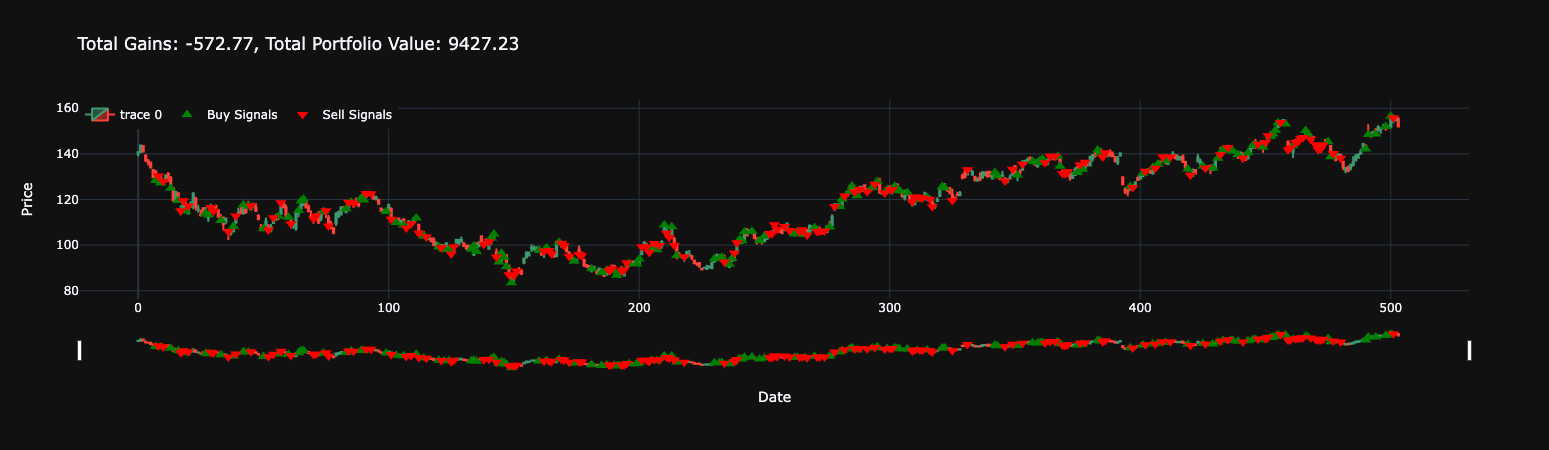